In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [ ]:
import pandas as pd

In [ ]:

df_train = pd.read_csv('/content/drive/My Drive/Diabetic Retinopathy/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Diabetic Retinopathy/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)

 
    return image

(3112,) (3112,) (550,) (550,)


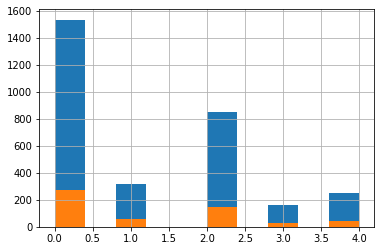

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=0)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

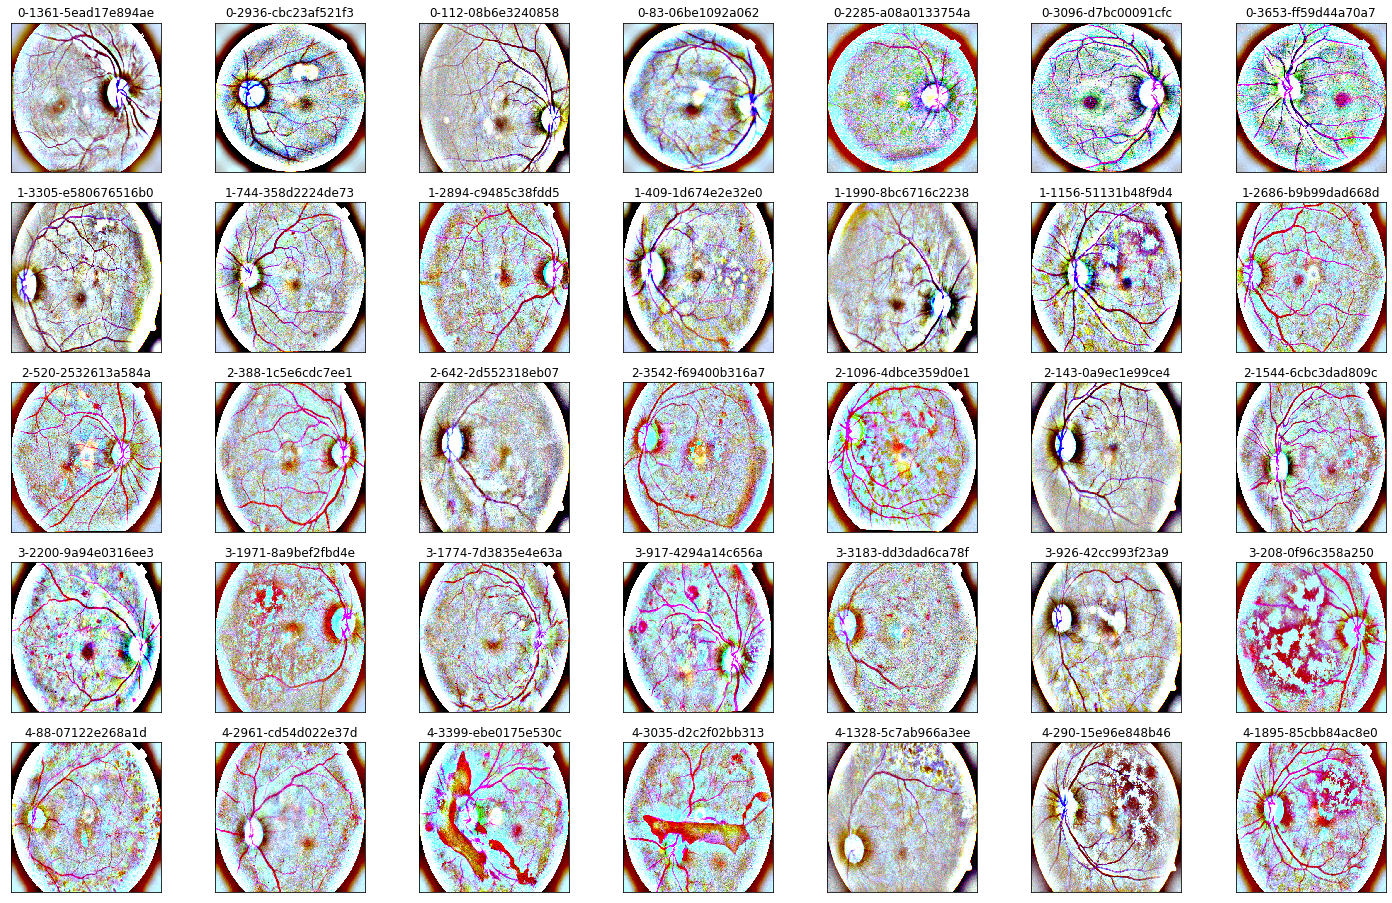

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [ ]:
import numpy as np

In [ ]:
def adjust_gamma(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

In [ ]:
def extract_ma(image):
    r,g,b=cv2.split(image)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
    
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
    
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening

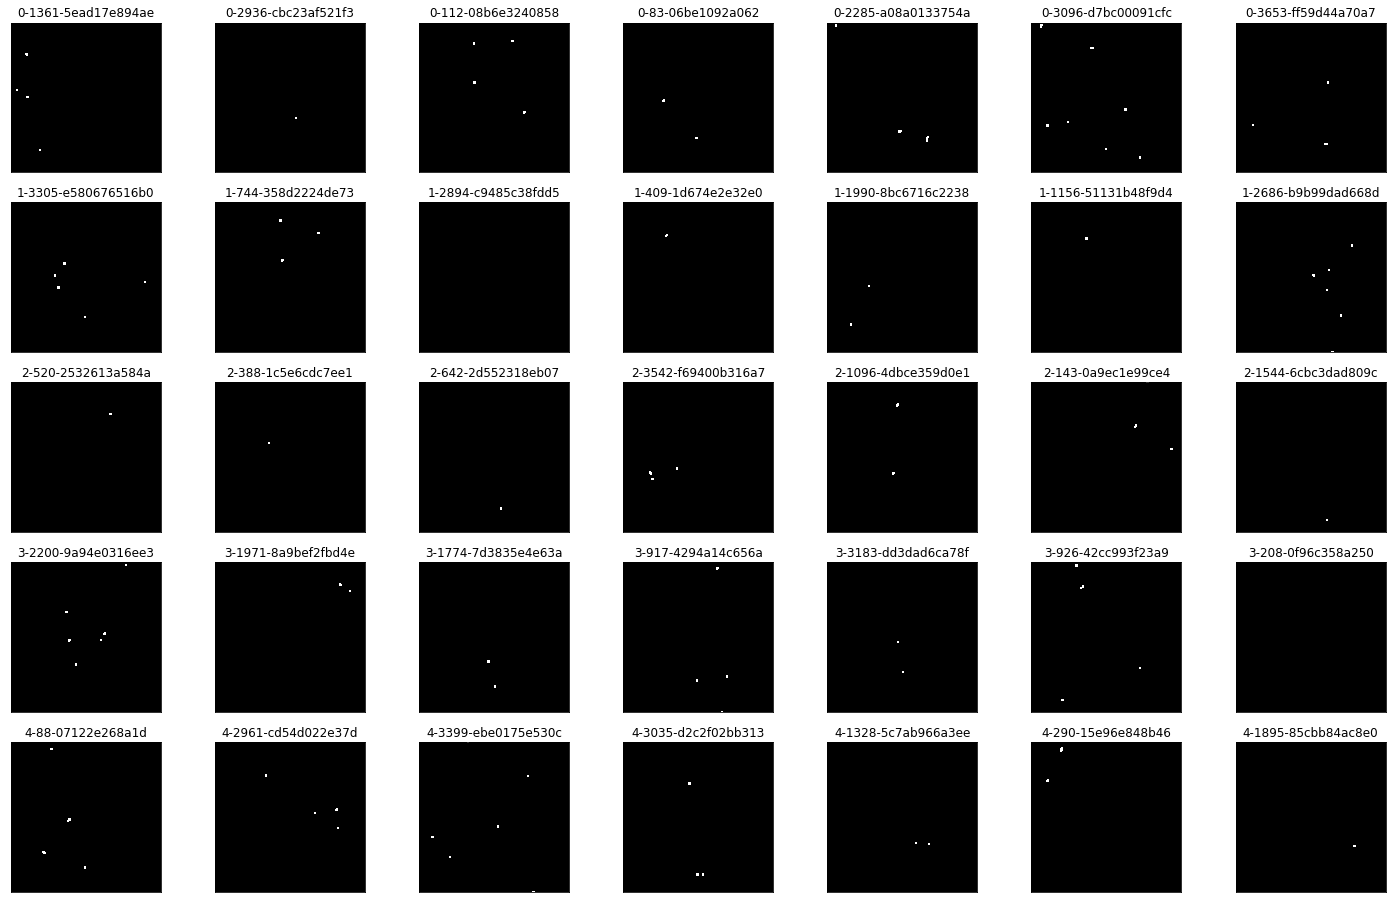

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        fundus=cv2.imread(path)
        bloodvessel = extract_ma(fundus)
        # img = cv2.imread(bloodvessel, cv2.IMREAD_GRAYSCALE)
        # n_white_pix = np.sum(img == 255)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [ ]:
import cv2
import numpy as np

img = cv2.imread('img.png', cv2.IMREAD_GRAYSCALE)
n_white_pix = np.sum(img == 255)
print('Number of white pixels:', n_white_pix)

In [ ]:
def adjust_gamma(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

In [ ]:
def extract_ma(image):
    r,g,b=cv2.split(image)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
    
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
    
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening

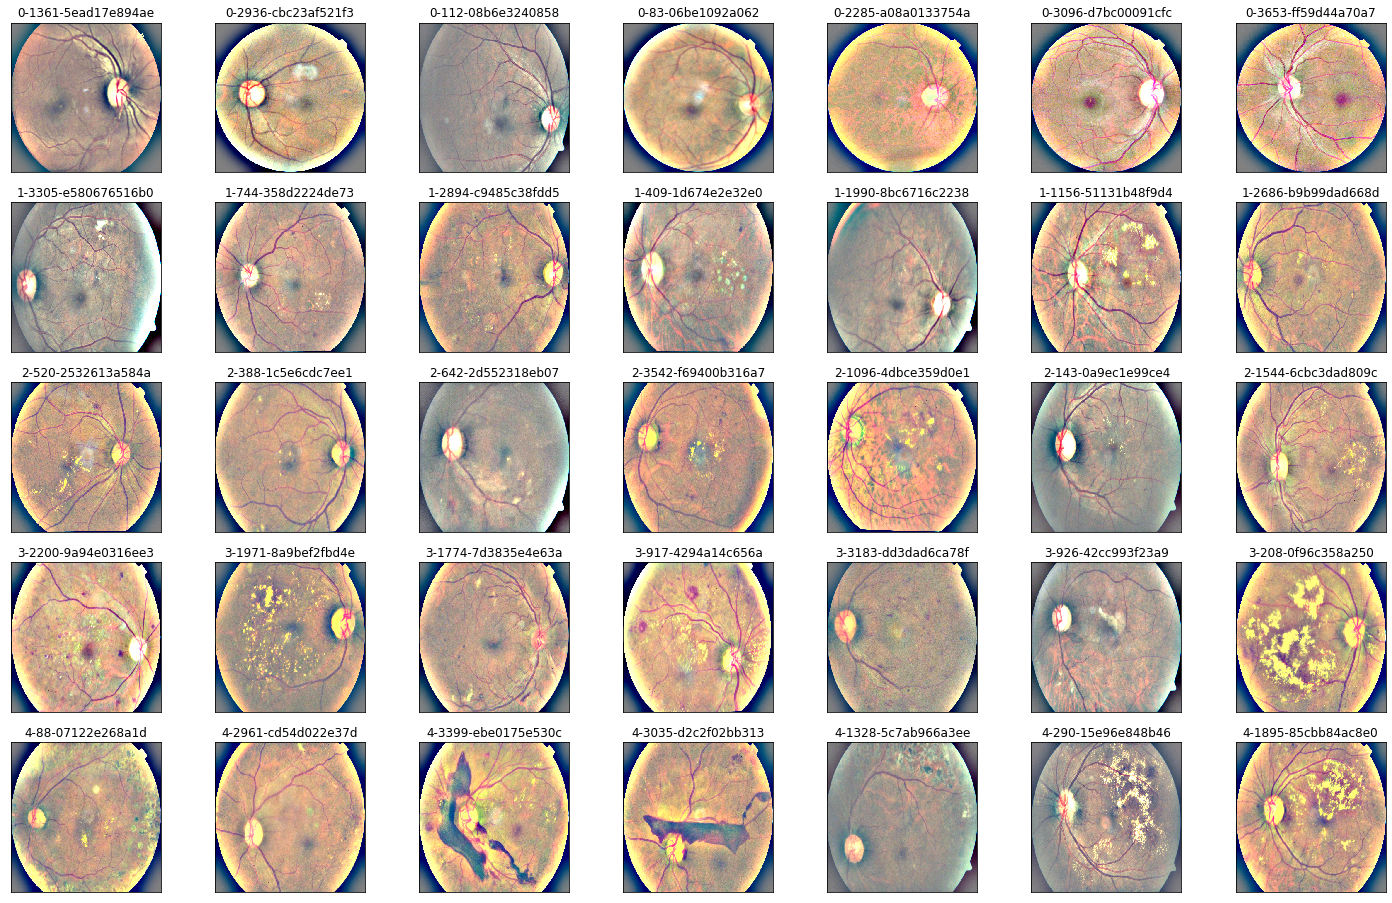

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        fundus=cv2.imread(path)
       
#         imag = rgb2gray(bloodvessel)
        plt.imshow(fundus,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [ ]:
https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html

In [ ]:
pip install SimpleCV


     |████████████████████████████████| 215kB 3.5MB/s 
  Created wheel for SimpleCV: filename=SimpleCV-1.3-cp36-none-any.whl size=242878 sha256=2458ebb7197e1b26724ac833d8b3ee3a089d49f6f8fe859cea5523b7597ac2d5
  Stored in directory: /root/.cache/pip/wheels/0a/37/85/f36f8beb60ae18f5f3c710e3e791aa3546579ab33ff0902d51
Successfully built SimpleCV


In [ ]:
def extract_bv(image):
  b,green_fundus,r = cv2.split(image)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  contrast_enhanced_green_fundus = clahe.apply(green_fundus)
  # applying alternate sequential filtering (3 times closing opening)
  r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
  f5 = clahe.apply(f4)

  # removing very small contours through area parameter noise removal
  ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
  mask = np.ones(f5.shape[:2], dtype="uint8") * 255
  print(f6.copy())
  print(cv2.RETR_LIST)
  print(cv2.CHAIN_APPROX_SIMPLE)
  im2, contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

  for cnt in contours:
    if cv2.contourArea(cnt) <= 200:
      cv2.drawContours(mask, [cnt], -1, 0, -1)			
  im = cv2.bitwise_and(f5, f5, mask=mask)
  ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
  newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

  # removing blobs of microaneurysm & unwanted bigger chunks taking in consideration they are not straight lines like blood
  # vessels and also in an interval of area
  fundus_eroded = cv2.bitwise_not(newfin)
  xmask = np.ones(image.shape[:2], dtype="uint8") * 255
  x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
  for cnt in xcontours:
    shape = "unidentified"
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
    if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
      shape = "circle"	
    else:
      shape = "veins"
    if(shape=="circle"):
      cv2.drawContours(xmask, [cnt], -1, 0, -1)	
	
  finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
  blood_vessels = cv2.bitwise_not(finimage)
  dilated = cv2.erode(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations=1)
  #dilated1 = cv2.dilate(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
  blood_vessels_1 = cv2.bitwise_not(dilated)
  return blood_vessels_1

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1
2


ValueError: ignored

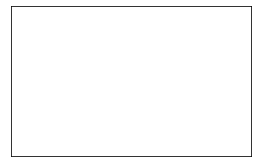

In [ ]:

fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        fundus=cv2.imread(path)
        fundus=extract_bv(fundus)
      
        
        image = cv2.resize(imag, (100, 100))
        plt.imshow(fundus,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

# fig = plt.figure(figsize=(25, 16))
# # display 10 images from each class
# for class_id in sorted(train_y.unique()):
#     for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
#         ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
#         path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/{row['id_code']}.png"
#         image = cv2.imread(path)
#         # imag = extract_bv(image)
#         # imag = rgb2gray(imag)
#         # image = cv2.resize(imag, (IMG_SIZE, IMG_SIZE))
         
#         plt.imshow(image,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
#         ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

ValueError: ignored

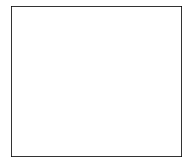

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        fundus=cv2.imread(path)
        bloodvessel = extract_bv(fundus)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [ ]:
jpeImg = 0
graImg = 0
cuImg = 0


def bloodv(img):
   jpeImg = img
   cuImg = np.array(img)
  ###Extracting Green Component
   gImg = cuImg[:,:,1]
   cuImg = gImg
   histEqImg = cv2.equalizeHist(cuImg)
   cuImg = histEqImg    
   gray = cuImg
   if gray.ndim > 2:
        raise Exception("illegal argument: input must be a single channel image (gray)")
        kernelG1 = np.array([[ 5,  5,  5],
                             [-3,  0, -3],
                             [-3, -3, -3]], dtype=np.float32)
        kernelG2 = np.array([[ 5,  5, -3],
                             [ 5,  0, -3],
                             [-3, -3, -3]], dtype=np.float32)
        kernelG3 = np.array([[ 5, -3, -3],
                             [ 5,  0, -3],
                             [ 5, -3, -3]], dtype=np.float32)
        kernelG4 = np.array([[-3, -3, -3],
                             [ 5,  0, -3],
                             [ 5,  5, -3]], dtype=np.float32)
        kernelG5 = np.array([[-3, -3, -3],
                             [-3,  0, -3],
                             [ 5,  5,  5]], dtype=np.float32)
        kernelG6 = np.array([[-3, -3, -3],
                             [-3,  0,  5],
                             [-3,  5,  5]], dtype=np.float32)
        kernelG7 = np.array([[-3, -3,  5],
                             [-3,  0,  5],
                             [-3, -3,  5]], dtype=np.float32)
        kernelG8 = np.array([[-3,  5,  5],
                             [-3,  0,  5],
                             [-3, -3, -3]], dtype=np.float32)
    
        g1 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG1), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g2 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG2), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g3 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG3), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g4 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG4), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g5 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG5), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g6 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG6), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g7 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG7), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        g8 = cv2.normalize(cv2.filter2D(gray, cv2.CV_32F, kernelG8), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        magn = cv2.max(g1, cv2.max(g2, cv2.max(g3, cv2.max(g4, cv2.max(g5, cv2.max(g6, cv2.max(g7, g8)))))))
        cuImg = magn
   ret, threshImg = cv2.threshold(cuImg,160,180,cv2.THRESH_BINARY_INV)
   cuImg = threshImg     
   cleanImg = morphology.remove_small_objects(cuImg, min_size=130, connectivity=100)
   cuImg = cleanImg 
   plt.imshow(cuImg,cmap=plt.get_cmap('gray'), vmin=0, vmax=255) 

IndexError: ignored

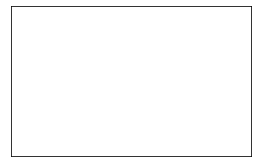

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray

        
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        imag = bloodv(image)
        #imag = rgb2gray(imag)
        #image = cv2.resize(imag, (IMG_SIZE, IMG_SIZE))
         
        # plt.imshow(image,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )
